In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
import json, shutil, random
from tqdm import tqdm
from datetime import datetime
from omegaconf import OmegaConf
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from PIL import Image
import torch
lt.monkey_patch()

sys.path.append("../../src")
from musubi_tuner.fpack_1fmc_generate import FramePack_1fmc
from musubi_tuner.frame_pack.hunyuan_video_packed import attn_cache
from musubi_tuner.utils.preproc_utils import getres, get_info_from_vistorybench, parse_bodylayout
from musubi_tuner.utils.viz_utils import convert_result_to_df_wpose, annot_viz, draw_final_img
from musubi_tuner.utils.attn_utils import get_img_attn_map

# sys.path.append("/home/yo564250/workspace/whisperer/datasets/storyviz/vistorybench")
sys.path.append("/projects/bffz/ykwon4/vistorybench/")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset
# vistory_dataset_path = Path("/groups/chenchen/patrick/ViStoryBench/dataset/ViStory")
vistory_dataset_path = Path("/projects/bffz/ykwon4/vistorybench/data/dataset/ViStory")
vistory_dataset = StoryDataset(vistory_dataset_path)

/u/ykwon4/.conda/envs/myenv/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/u/ykwon4/.conda/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:Xformers is not installed!
INFO:root:Flash Attn is not installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention
model_path is /projects/bffz/ykwon4/musubi-tuner/src/practice/../../src/musubi_tuner/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /projects/bffz/ykwon4/musubi-tuner/src/practice/../../src/musubi_tuner/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


/u/ykwon4/.conda/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/u/ykwon4/.conda/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [2]:
framepack_model = FramePack_1fmc(
    dit_path = "/projects/bffz/ykwon4/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors",
    vae_path = "/projects/bffz/ykwon4/ComfyUI/models/vae/hunyuan-video-t2v-720p-vae.pt",
    text_encoder1_path = "/projects/bffz/ykwon4/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors",
    text_encoder2_path = "/projects/bffz/ykwon4/ComfyUI/models/text_encoders/clip_l.safetensors",
    lora_path = "/work/nvme/bffz/ykwon4/musubi-training/idmask_control_lora_wrope_v3/idmask_control_lora_wrope_v3-3-step00003000.safetensors"
)
# framepack_model = FramePack_1fmc(
#     lora_path = "/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/outputs/training/idmask_control_lora_wrope_v3/idmask_control_lora_wrope_v3_1-step00003000.safetensors"
# )

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /projects/bffz/ykwon4/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda:0
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /projects/bffz/ykwon4/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from /work/nvme/bffz/ykwon4/musubi-training/idmask_control_lora_wrope_v3/idmask_control_lora_wrope_v3-3-step00003000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA f

Model, VAE, Text Encoders, LoRA loaded.


In [23]:
main_layout_path = Path("/projects/bffz/ykwon4/vistorybench/data/gen_layouts_bulk/20250927_101053")
# main_layout_path = Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20250927_101053")
story_num = '24'
shot_num = 5

story = vistory_dataset.load_story(story_num)
story_dict = {x['index']:x for x in story['shots']}
vanila_shot, vanila_character_shot, _ = get_info_from_vistorybench(vistory_dataset, story_num, 1)

shot_num = int(shot_num)
story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
prompt = story_shot['type'] + ";" + prompt

layouts = [
    (x.stem, list(map(int, x.stem.split("-pages_")[-1].split("_")))) 
    for x in  list(main_layout_path.glob(f"story_{story_num}*"))]
layout_name = [(x[0], x[1][0]) for x in layouts if shot_num in range(x[1][0], x[1][1]+1)][0]
author_output_dir = main_layout_path / layout_name[0]

layout = parse_bodylayout(author_output_dir / "pose_layout.json")
panel_bbox, panel_layout = layout[f'[PANEL-{shot_num-layout_name[1]+1}]']
width, height = getres(panel_bbox[2]-panel_bbox[0], panel_bbox[3]-panel_bbox[1], 
    target_area=1344*768, max_aspect_ratio=2.0)

# panel_layout = {0: {'bbox': [0.4, 0.1, 0.7, 0.9], 'body': []}}

print(prompt)
print(panel_layout)
print(characters_shot)

# prev_output_path = Path("/groups/chenchen/patrick/ViStoryBench/outputs/whisperer/v2_multi_tmp_2000/en/20251018_220036")
# shutil.copytree(prev_output_path / story_num, f"tmp/{story_num}", dirs_exist_ok=True)

Realistic, Classics for Women;Realistic, Classics for Women;Medium shot, eye level shot;Amy stands by the window, her hands resting on the windowsill as she watches the falling snow outside, her eyes revealing a hint of jealousy and longing, her lips slightly downturned.;Daytime, the March family's living room, by the window, snow falling outside, faint sunlight streaming through the window onto the floor.;The youngest sister Amy is filled with envy for the girls from wealthy families.;Amy is A twelve-year-old American girl, sweet and adorable, with golden eyes and golden ringlets.;
{0: {'bbox': [0.734, 0.024, 0.998, 0.987], 'body': array([[0.865, 0.172],
       [0.889, 0.306],
       [0.843, 0.143],
       [0.906, 0.143]])}, 1: {'bbox': [0.217, 0.29, 0.826, 0.987], 'body': array([[0.428, 0.507],
       [0.483, 0.608],
       [0.38 , 0.473],
       [0.465, 0.456]])}}
{'Amy': {'name': 'Amy', 'key': 'Amy', 'prompt': 'A twelve-year-old American girl, sweet and adorable, with golden eyes a

In [40]:
type(v['bbox'][0])

float

In [ ]:
for k,v in panel_layout.items():
    if len(v['bbox']) > 0:
        if v['bbox'][0] < 1:
            print(list(map(lambda x: int(x*1000), v['bbox'])))
    if len(v['body']) > 0:
        if v['body'][0][0] < 1:
            print((v['body']*1000).astype(int))
        

[734, 24, 998, 987]
,
[[865 172]
 [889 306]
 [843 143]
 [906 143]]
[217, 290, 826, 987]
,
[[428 507]
 [483 608]
 [380 473]
 [465 456]]


In [27]:
page_sub = convert_result_to_df_wpose(panel_layout, 768, 1024)
final_layout = annot_viz(Image.new("RGB", (768, 1024), (0,0,0)), page_sub, label_col='frame_id2')
final_layout

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U21'), dtype('float64')) -> None

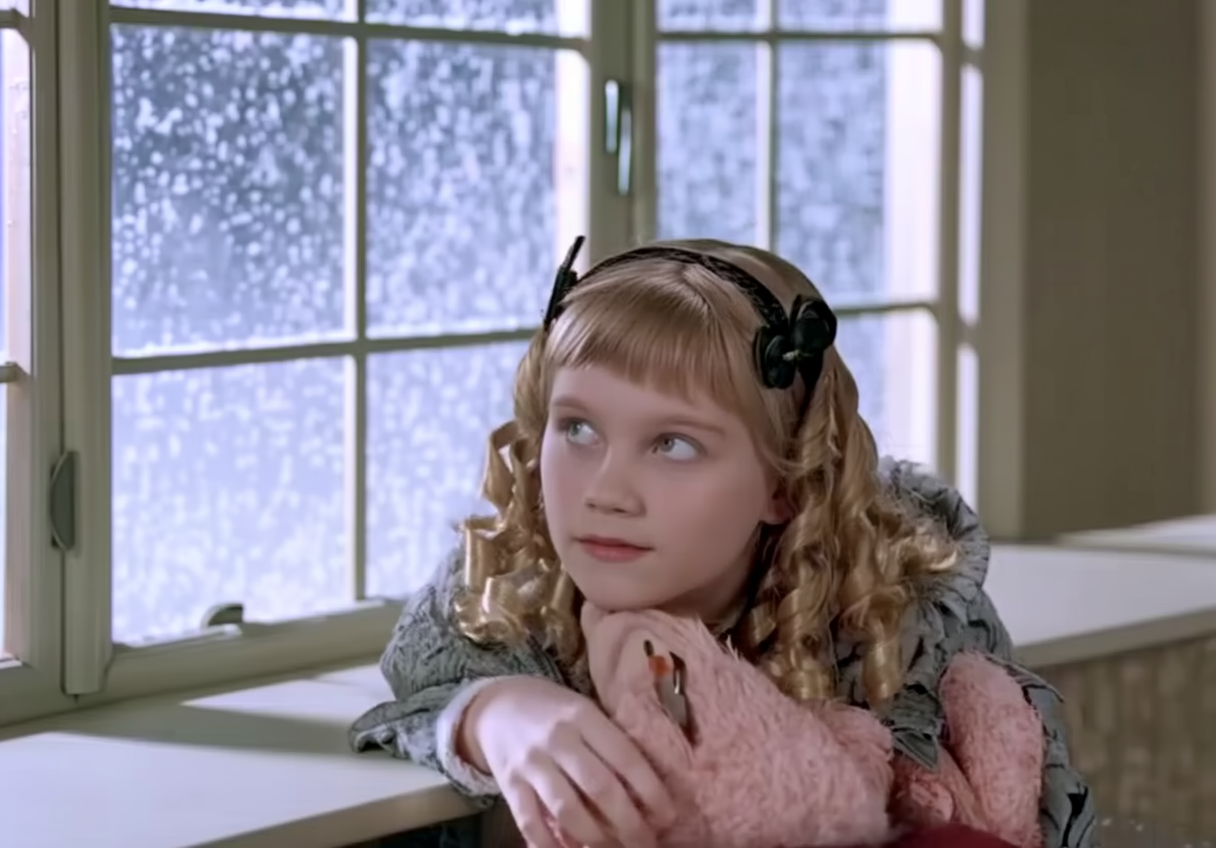

In [ ]:
import cv2

annot_img = np.zeros((512, 896, 3), dtype=np.uint8)

row = page_sub.iloc[1]
c1, c2 = list(map(int, [row.xmin+10, row.ymin])), list(map(int, [row.xmax+10, row.ymax]))
cv2.rectangle(annot_img, c1, c2, (246,198,173), thickness=10, lineType=cv2.LINE_AA)
cv2.rectangle(annot_img, c1, (c1[0]+140, c1[1]+40), (246,198,173), -1, cv2.LINE_AA)  # filled
cv2.putText(annot_img, 'BOX #1', (c1[0]+10, c1[1]+30), 0, 1, [225, 255, 255], thickness=2, lineType=cv2.LINE_4)

row = page_sub.iloc[2]
c1, c2 = list(map(int, [row.xmin, row.ymin])), list(map(int, [row.xmax, row.ymax]))
cv2.rectangle(annot_img, c1, c2, (132,226,145), thickness=10, lineType=cv2.LINE_AA)
cv2.rectangle(annot_img, c1, (c1[0]+140, c1[1]+40), (132,226,145), -1, cv2.LINE_AA)  # filled
cv2.putText(annot_img, 'BOX #2', (c1[0]+10, c1[1]+30), 0, 1, [225, 255, 255], thickness=2, lineType=cv2.LINE_4)

Image.fromarray(annot_img)

100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


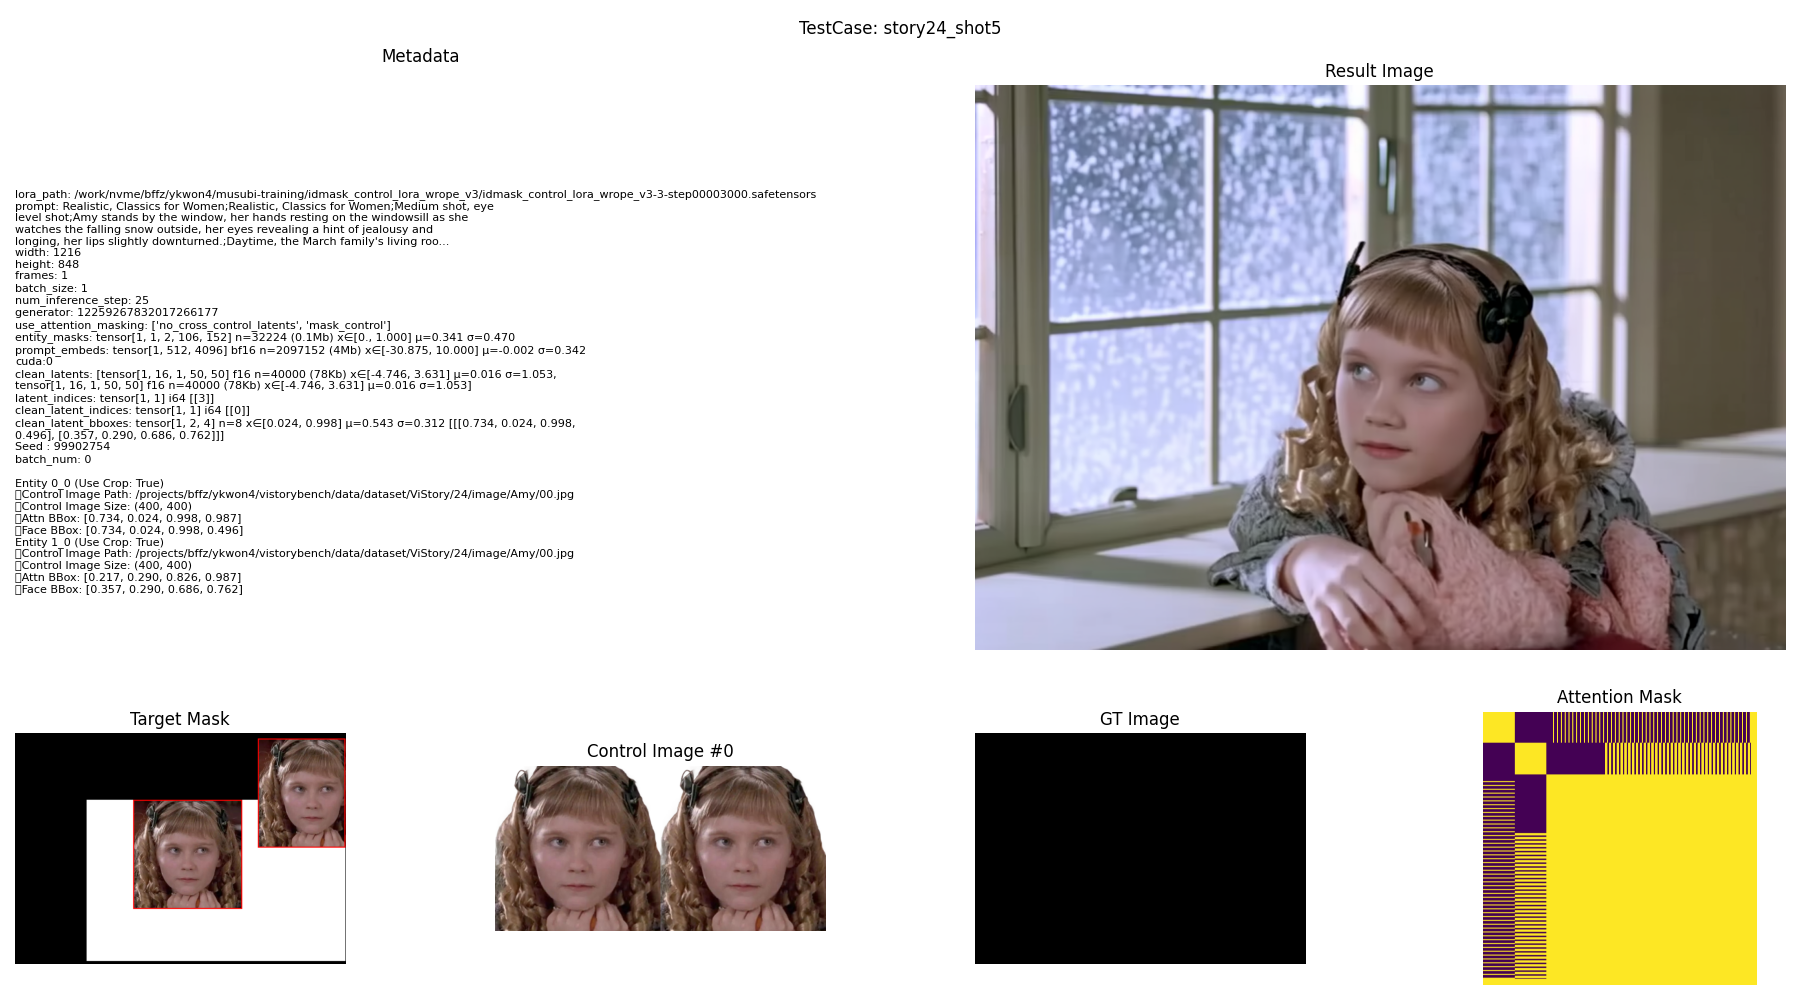

In [24]:
seed = np.random.randint(2**31)
result_imgs, debug_imgs, debug_mask = framepack_model(
    prompt, panel_layout, characters_shot, width, height,
    c_width_given=400, seed=seed, crop_face_detect=True, use_rembg=True,
    cache_results=False, cache_layers=[], 
    use_attention_masking=['no_cross_control_latents', 'mask_control'], 
    debug_name=f"story{story_num}_shot{shot_num}"
)
debug_imgs[0]

In [ ]:
from musubi_tuner.utils.preproc_utils import postproc_imgs, get_text_preproc, get_all_control_kwargs
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan

# tmp_ctoi = {list(characters_shot.keys())[i]: i for i in range(len(characters_shot))}
# tmp_c = [{k+f"-{i}": {'images': [v['images'][i]]} for i in range(len(v['images']))} for k,v in characters_shot.items()]
# tmp_c = {k:v for x in tmp_c for k,v in x.items()}
# tmp_p = {i: panel_layout[tmp_ctoi[list(tmp_c.keys())[i].split('-')[0]]] for i in range(len(tmp_c))}

seed = np.random.randint(2**31)
print(seed)
text_kwargs = get_text_preproc(prompt, 
    framepack_model.text_encoder1, framepack_model.text_encoder2, framepack_model.tokenizer1, framepack_model.tokenizer2, 
    entity_prompts=[], device=framepack_model.device)

control_kwargs, entity_masks, control_nps, debug_mask, print_res = get_all_control_kwargs(
    panel_layout, characters_shot, framepack_model.vae, width=width, height=height,
    crop_face_detect=True, use_rembg=True, 
    c_width_given=400, bbox_mode='provided_size_mid_x',
    control_indices=[0], latent_indices=[3], max_chara_imgs=2, max_chara=2,
)
print(print_res)
# control_kwargs['clean_latent_bboxes'] = torch.tensor([[[0.,0.,1.,1.]]])

generator = torch.Generator(device="cpu")
generator.manual_seed(seed)
total_kwargs = {
    'prompt': prompt, 'sampler': 'unipc', 'width': width, 'height': height, 'frames': 1, 'batch_size': 1,
    'num_inference_step': 25, 'generator': generator, 'device': framepack_model.device, 'dtype': framepack_model.dtype,
    'cache_results': True, 'cache_layers': [],
    'use_attention_masking': ['no_cross_control_latents'],
    'entity_masks': entity_masks,
}
# attn_cache.clear()
results = sample_hunyuan(transformer=framepack_model.model, **total_kwargs, **text_kwargs, **control_kwargs,)

result_img = Image.fromarray(postproc_imgs(results[0:1], framepack_model.vae)[0])
result_img

# Image.fromarray(np.sum(entitymask_nps, axis=0)>0).convert("RGB")

In [ ]:
block_id=f'transformer_blocks.8'
t_0=0
t_1=25
normalize=True

timesteps = sorted(list(attn_cache[block_id].keys()), reverse=False)
token_H, token_W = height // 16, width // 16
clean_latent_inds = attn_cache['attn_dict']['clean_latents']
noise_inds = attn_cache['attn_dict']['noise']

timesteps = sorted(list(attn_cache[block_id].keys()), reverse=False)
attention_probs = sum(attn_cache[block_id][timesteps[t]][:,noise_inds[0][0]:noise_inds[0][1],:] for t in range(t_0, t_1))
attention_map = rearrange(attention_probs, 'B (H W) D -> B H W D', H=token_H, W=token_W)
attention_map = attention_map.permute(0,3,1,2)
attention_map = attention_map[0,clean_latent_inds[0][0]:clean_latent_inds[-1][1],:,:].mean(axis=0)

if normalize:
    attention_map -= attention_map.min(1, keepdim=True)[0]
    attention_map /= attention_map.max(1, keepdim=True)[0]
print(attention_map.shape)

fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.imshow((attention_map.to(dtype=torch.float32).cpu().numpy()*255).astype(np.uint8), cmap='viridis')
ax.axis("off")
plt.show()

In [ ]:
results_dict_temp = {}
for i in range(9):
    seed = np.random.randint(2**31)
    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=320, seed=seed, crop_face_detect=True, use_rembg=True,
        debug_name=f"story{story_num}_shot{shot_num}"
    )

    results_dict_temp[i] = {
        'seed' : seed,
        'result_img': result_imgs[0], 'debug_img': debug_imgs[0],
        'debug_mask': debug_mask,
    }

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, (key, value) in enumerate(results_dict_temp.items()):
    ax[i // 3, i % 3].imshow(value['result_img'])
    ax[i // 3, i % 3].set_title(f"Seed {value['seed']}")
    ax[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()

# results_dict_temp[8]['result_img'].save(Path("tmp") / f"{story_num}/{shot_num-1}_0.png")
# results_dict_temp[8]['debug_img'].save(Path("tmp") / f"{story_num}/debug/{shot_num-1}_0.png")

In [ ]:
outputs_root = Path("/groups/chenchen/patrick/ViStoryBench/outputs/")
story_num = 77
shutil.copytree(
    f"/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/practice/tmp/{story_num}", 
    outputs_root / f"whisperer/v2_multi_tmp_2000/en/20251018_220036_v2/{story_num}_v2", 
    dirs_exist_ok=True
)

In [ ]:
# tmp = {
#     "[PANEL-1]": {"bbox": [520, 40, 960, 380], "body" : [[180, 120, 900, 960]]},
#     "[PANEL-2]": {"bbox":  [40, 40, 500, 380], "body" : [[120, 420, 880, 820]]},
#     "[PANEL-3]": {"bbox": [40, 400, 960, 960], "body" : [[60, 200, 620, 980],[420, 260, 720, 880],[740, 280, 960, 860]]}
# }
tmp = json.loads(Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20250927_101053/story_66-pages_1_6/pose_layout.json").read_text())


page_sub = convert_result_to_df_wpose(tmp, 768, 1024)
final_layout = annot_viz(Image.new("RGB", (768, 1024), (0,0,0)), page_sub, label_col='frame_id2')
final_layout